In [1]:
%%capture
!wget -O data.zip https://cutt.ly/iU2Um7u
!unzip data/data.zip -d data/

In [2]:
from math import sqrt
from IPython.display import Image
import pandas as pd

### Collaborative Filtering

Now, time to start our work on recommendation systems. 

The first technique we're going to take a look at is called **Collaborative Filtering**, which is also known as **User-User Filtering**. As hinted by its alternate name, this technique uses other users to recommend items to the input user. It attempts to find users that have similar preferences and opinions as the input and then recommends items that they have liked to the input. There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the **Pearson Correlation Function**.

The process for creating a User Based recommendation system is as follows:

- Select a user with the movies the user has watched
- Based on his rating to movies, find the top X neighbours 
- Get the watched movie record of the user for each neighbour.
- Calculate a similarity score using some formula
- Recommend the items with the highest score

The first step is to discover how similar the active user is to the other users. How do we do this? Well, this can be done through several different statistical and vectorial techniques such as distance or similarity measurements including Euclidean Distance, Pearson Correlation, Cosine Similarity, and so on. To calculate the level of similarity between two users, we use the three movies that both the users have rated in the past. Regardless of what we use for similarity measurement, let's say for example, the similarity could be 0.7, 0.9, and 0.4 between the active user and other users. These numbers represent similarity weights or proximity of the active user to other users in the dataset. 

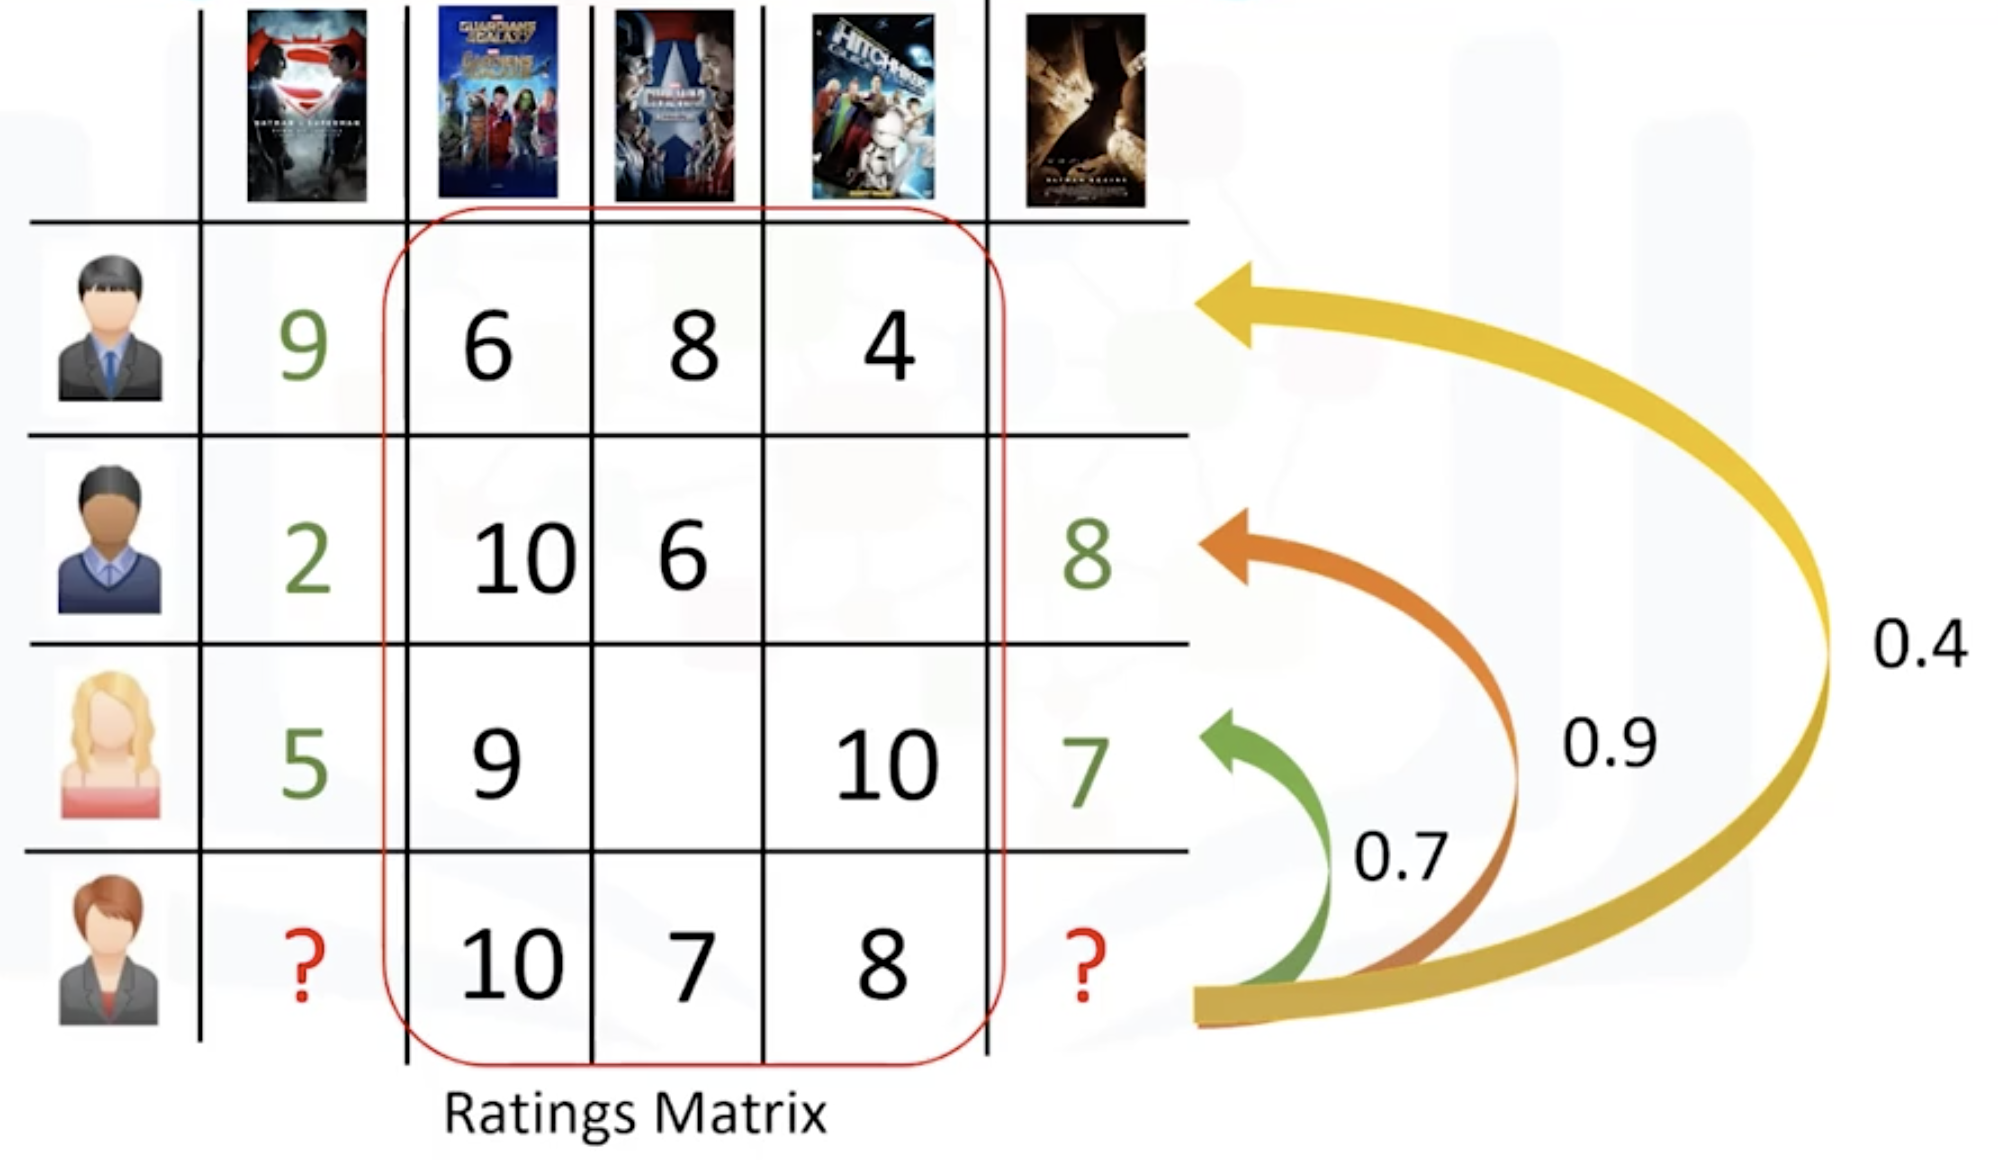

In [3]:
Image('img/form-6.png', width=800, height=400)

The next step is to create a weighted rating matrix. We just calculated the similarity of users to our active user in the previous slide. Now, we can use it to calculate the possible opinion of the active user about our two target movies. This is achieved by multiplying the similarity weights to the user ratings. It results in a weighted ratings matrix, which represents the user's neighbors opinion about are two candidate movies for recommendation. In fact, it incorporates the behavior of other users and gives more weight to the ratings of those users who are more similar to the active user. 

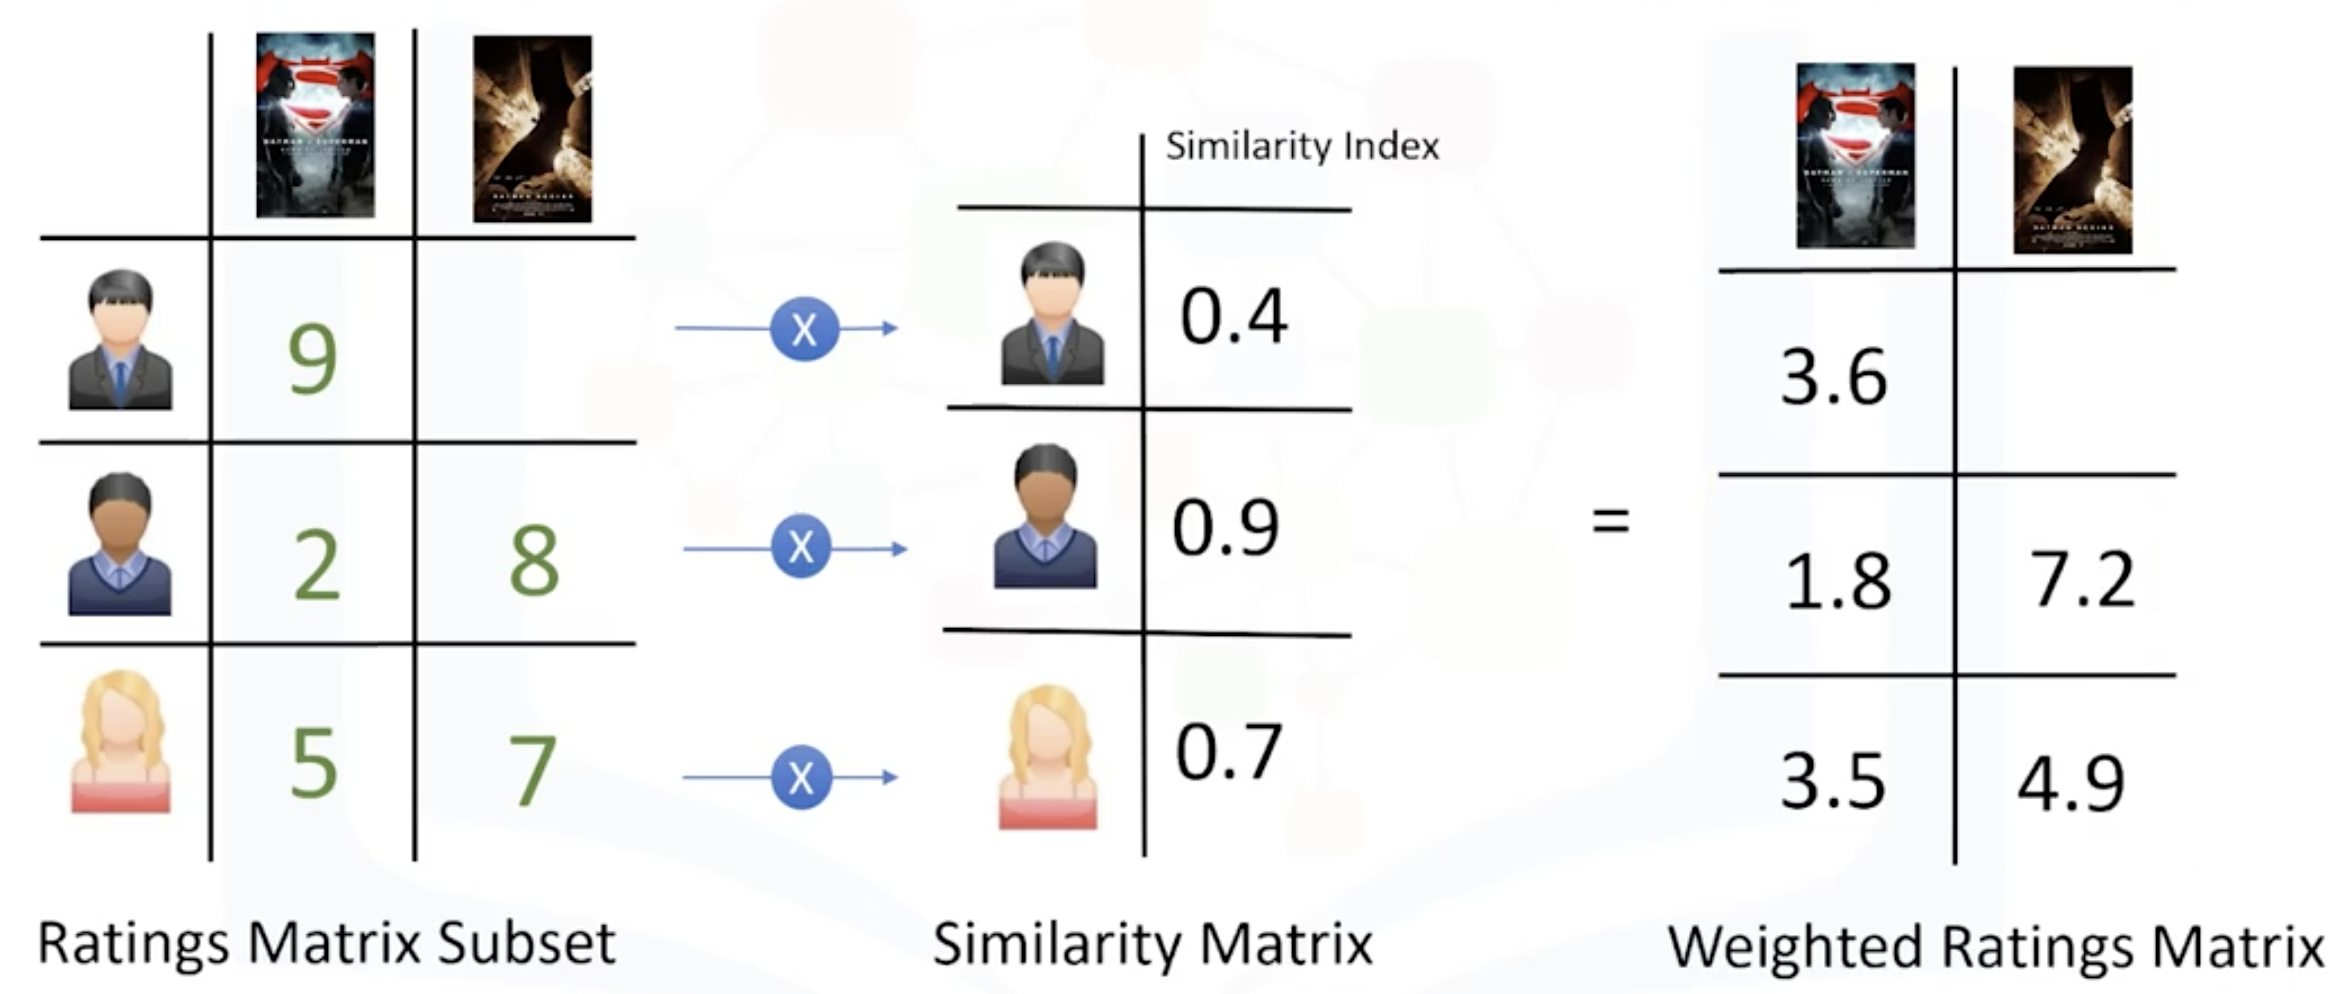

In [4]:
Image('img/form-7.png', width=800, height=400)

Now, we can generate the recommendation matrix by aggregating all of the weighted rates. However, as three users rated the first potential movie and two users rated the second movie, we have to normalize the weighted rating values. We do this by dividing it by the sum of the similarity index for users. The result is the potential rating that our active user will give to these movies based on her similarity to other users. It is obvious that we can use it to rank the movies for providing recommendation to our active user. 

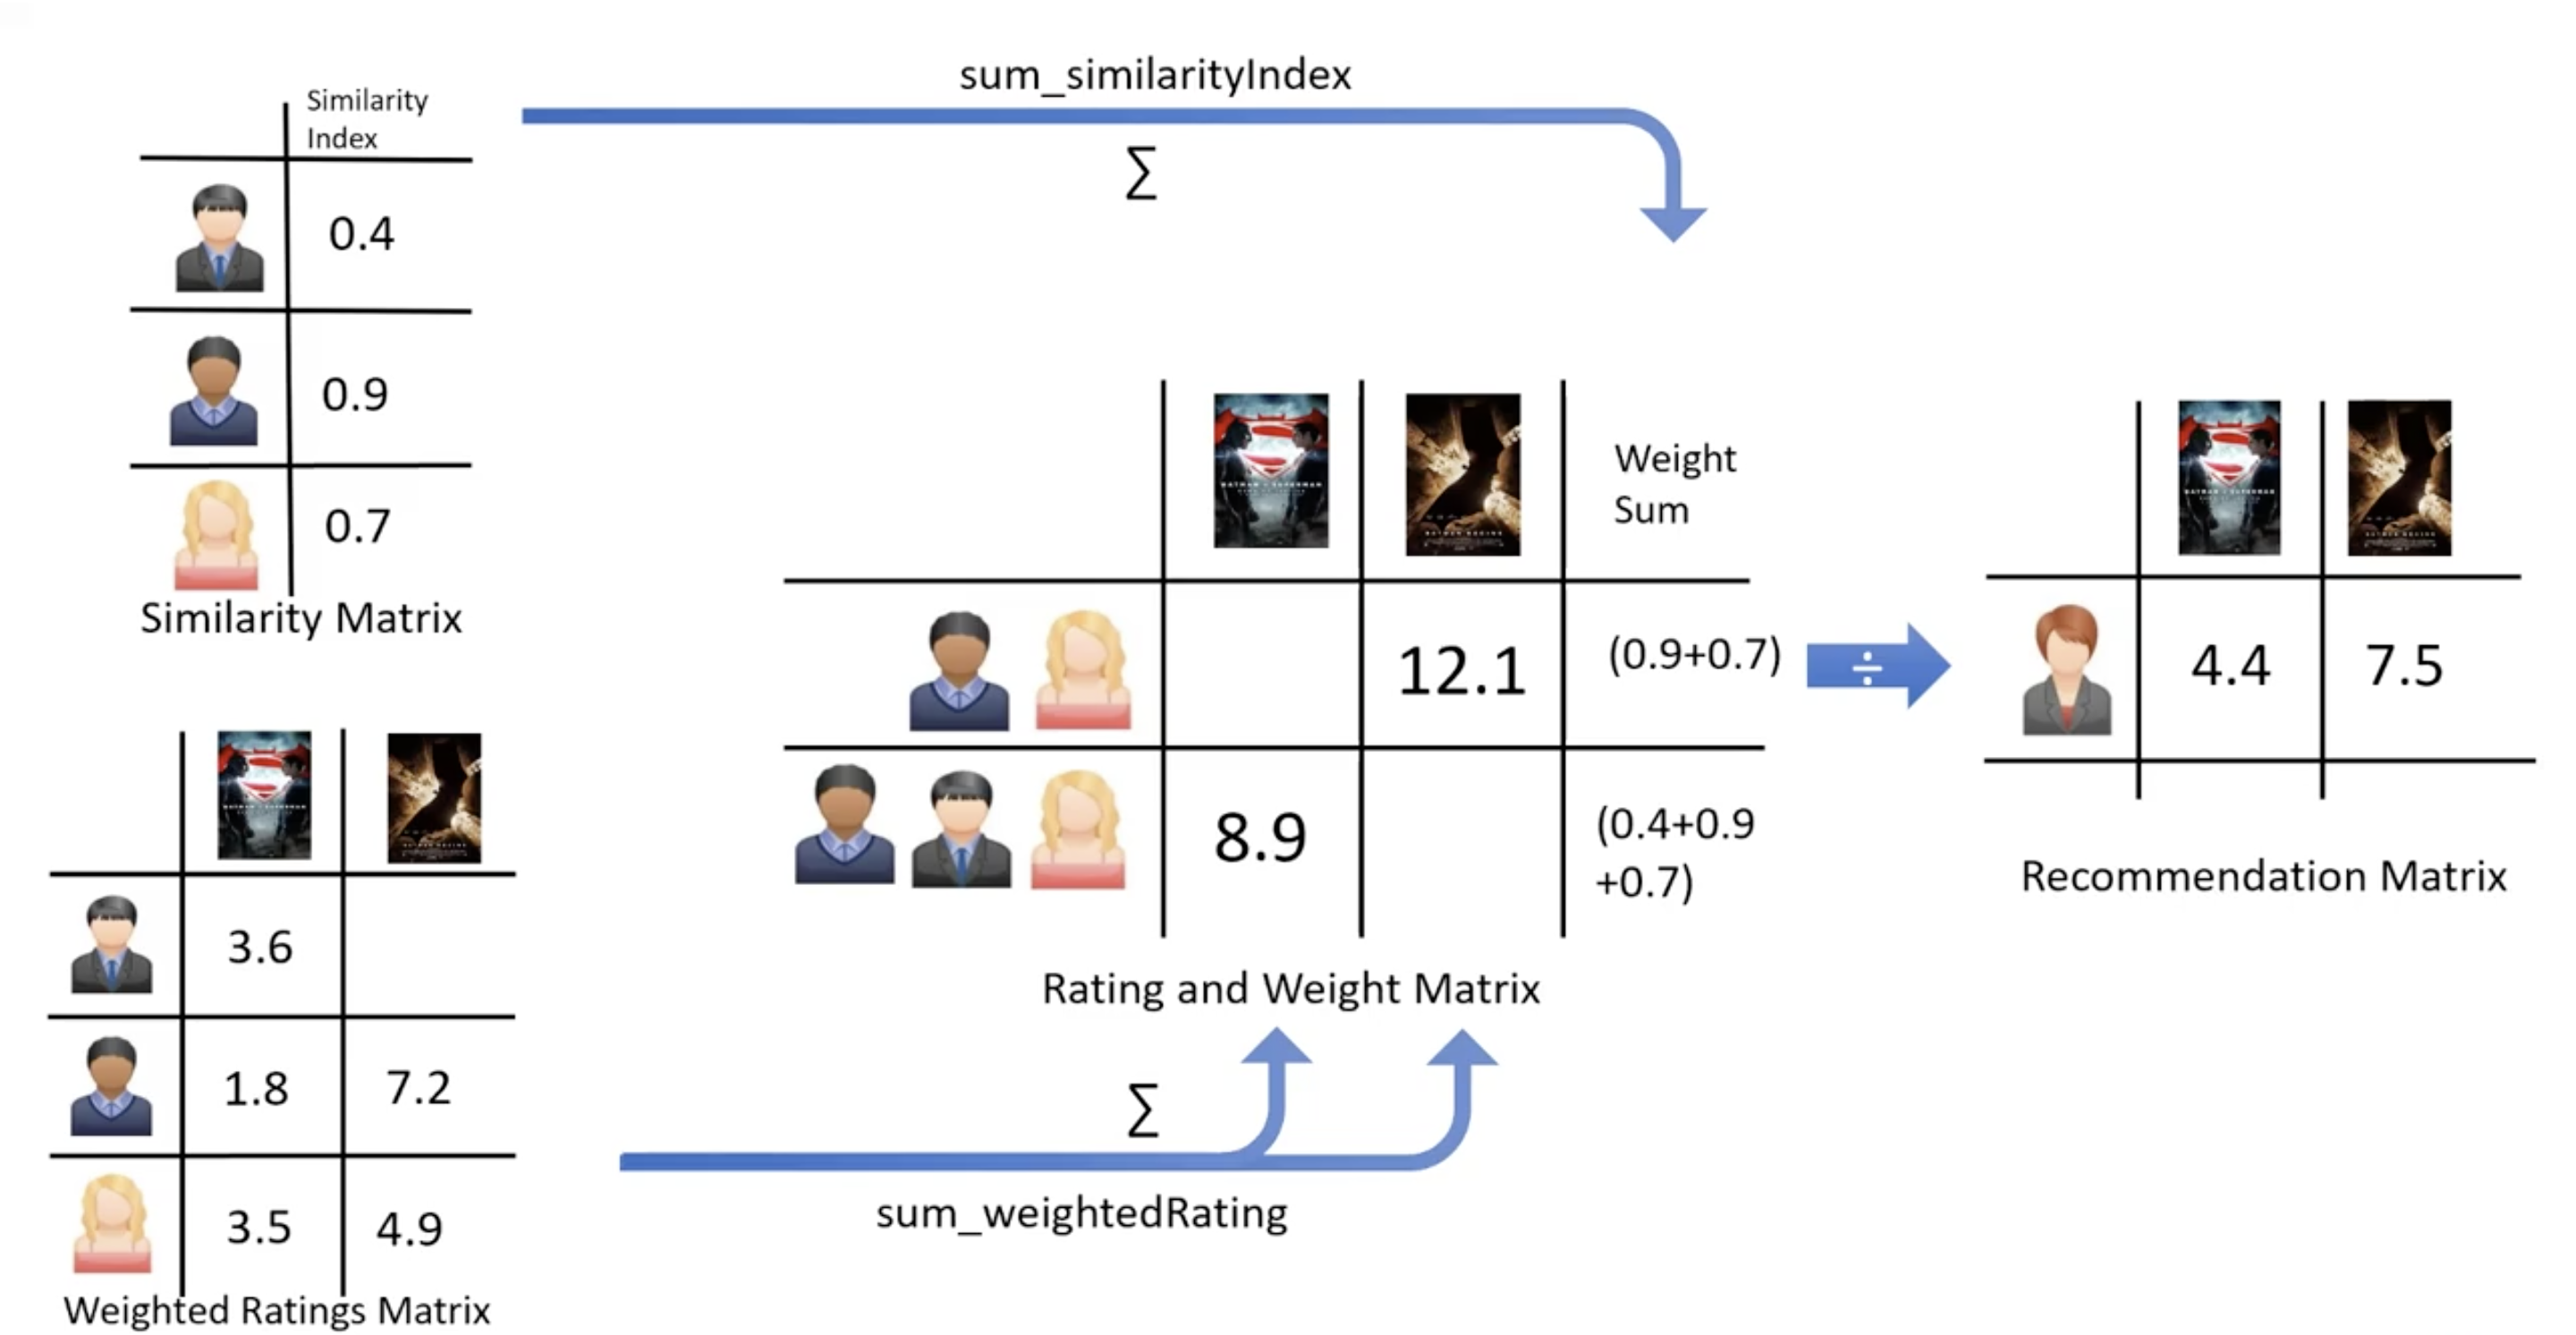

In [5]:
Image('img/form-8.png', width=800, height=400)

In [6]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')

In [7]:
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))', expand=False)
movies['year'] = movies.year.str.extract('(\d\d\d\d)', expand=False)
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
movies['title'] = movies['title'].apply(lambda x: x.strip())

In [8]:
movies = movies.drop('genres', axis=1)
ratings = ratings.drop('timestamp', axis=1)

In [9]:
user_input = [
    {
        'movieId': 1968,
        'title': 'Breakfast Club, The', 
        'rating': 5
    },
    {
        'movieId': 1,
        'title': 'Toy Story', 
        'rating': 3.5
    },
    {
        'movieId': 2,
        'title': 'Jumanji', 
        'rating': 2
    },
    {
        'movieId': 296,
        'title': 'Pulp Fiction', 
        'rating': 5
    },
    {
        'movieId': 1274,
        'title': 'Akira', 
        'rating': 4.5
    }
] 
input_movies = pd.DataFrame(user_input).sort_values('movieId').reset_index(drop=True)

In [10]:
user_movies = movies[movies['movieId'].isin(input_movies['movieId'].tolist())]
user_movies.head()

movieId                title  year
0           1            Toy Story  1995
1           2              Jumanji  1995
293       296         Pulp Fiction  1994
1246     1274                Akira  1988
1885     1968  Breakfast Club, The  1985

In [11]:
user_subset = ratings[ratings['movieId'].isin(input_movies['movieId'].tolist())]
user_subset.head()

userId  movieId  rating
19        4      296     4.0
441      12     1968     3.0
479      13        2     2.0
531      13     1274     5.0
681      14      296     2.0

In [12]:
grouped = user_subset.groupby(['userId'])

In [13]:
grouped = sorted(grouped,  key=lambda x: len(x[1]), reverse=True)

#### Similarity of users to input user

Next, we are going to compare all users (not really all !!!) to our specified user and find the one that is most similar.  
we're going to find out how similar each user is to the input through the **Pearson Correlation Coefficient**. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below. 

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 \* Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales.

The values given by the formula vary from r = -1 to r = 1, where 1 forms a direct correlation between the two entities (it means a perfect positive correlation) and -1 forms a perfect negative correlation. 

In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.

We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.

In [14]:
grouped = grouped[0: 100]

In [15]:
pearson_corr = {}

for name, group in grouped:
    group = group.sort_values(by='movieId')
    input_movies = input_movies.sort_values(by='movieId')
    n_ratings = len(group)
    
    temp = input_movies[input_movies['movieId'].isin(group['movieId'].tolist())]
    temp_ratings = temp['rating'].tolist()
    temp_groups = group['rating'].tolist()
    
    sxx = sum([i ** 2 for i in temp_ratings]) - pow(sum(temp_ratings), 2) / float(n_ratings)
    syy = sum([i ** 2 for i in temp_groups]) - pow(sum(temp_groups), 2) / float(n_ratings)
    sxy = sum(i * j for i, j in zip(temp_ratings, temp_groups)) - sum(temp_ratings) * sum(temp_groups) / float(n_ratings)
    
    if sxx != 0 and syy != 0:
        pearson_corr[name] = sxy / sqrt(sxx * syy)
    else:
        pearson_corr[name] = 0

In [16]:
pearson_df = pd.DataFrame.from_dict(pearson_corr, orient='index')
pearson_df.columns = ['similarity']
pearson_df['userId'] = pearson_df.index
pearson_df.index = range(len(pearson_df))
pearson_df.head()

similarity  userId
0    0.827278      75
1    0.586009     106
2    0.832050     686
3    0.576557     815
4    0.943456    1040

In [17]:
top_users = pearson_df.sort_values(by='similarity', ascending=False)[0:50]
top_users.head()

similarity  userId
64    0.961678   12325
34    0.961538    6207
55    0.961538   10707
67    0.960769   13053
4     0.943456    1040

#### Rating of selected users to all movies

We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our **pearson_df** from the ratings dataframe and then store their correlation in a new column called \_similarityIndex". This is achieved below by merging of these two tables.

In [18]:
top_ratings = top_users.merge(ratings, left_on='userId', right_on='userId')

Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:

In [19]:
top_ratings['weighted_rating'] = top_ratings['similarity'] * top_ratings['rating']
top_ratings.head()

similarity  userId  movieId  rating  weighted_rating
0    0.961678   12325        1     3.5         3.365874
1    0.961678   12325        2     1.5         1.442517
2    0.961678   12325        3     3.0         2.885035
3    0.961678   12325        5     0.5         0.480839
4    0.961678   12325        6     2.5         2.404196

In [20]:
temp = top_ratings.groupby('movieId').sum()[['similarity','weighted_rating']]
temp.columns = ['sum_similarity','sum_weighted_rating']
temp.head()

sum_similarity  sum_weighted_rating
movieId                                     
1             38.376281           140.800834
2             38.376281            96.656745
3             10.253981            27.254477
4              0.929294             2.787882
5             11.723262            27.151751

In [21]:
rec_df = pd.DataFrame()
rec_df['recommendation_score'] = temp['sum_weighted_rating'] / temp['sum_similarity']
rec_df['movieId'] = temp.index
rec_df.head()

recommendation_score  movieId
1              3.668955        1
2              2.518658        2
3              2.657941        3
4              3.000000        4
5              2.316058        5

In [22]:
rec_df = rec_df.sort_values(by='recommendation_score', ascending=False)

In [23]:
movies.loc[movies['movieId'].isin(rec_df.head(10)['movieId'].tolist())]

movieId                                    title  year
2200      2284                             Bandit Queen  1994
3243      3329                 Year My Voice Broke, The  1987
3669      3759                       Fun and Fancy Free  1947
3679      3769                Thunderbolt and Lightfoot  1974
3685      3775                          Make Mine Music  1946
4978      5073  Son's Room, The (Stanza del figlio, La)  2001
6563      6672                         War Photographer  2001
6667      6776        Lagaan: Once Upon a Time in India  2001
9064     26801      Dragon Inn (Sun lung moon hak chan)  1992
18106    90531                                    Shame  2011

#### Advantages and Disadvantages of Collaborative Filtering

##### Advantages

- Takes other user's ratings into consideration
- Doesn't need to study or extract information from the recommended item
- Adapts to the user's interests which might change over time

##### Disadvantages

- Approximation function can be slow
- There might be a low of amount of users to approximate
- Privacy issues when trying to learn the user's preferences